In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from subprocess import call
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
import random

In [91]:
random.seed()

def make_input(particles, ndim, time, limit):
    input = open('input.txt', 'w')
    input.write(str(particles) + '\n')
    input.write(str(ndim) + '\n')
    input.write(str(time) + '\n')
    for i in range(particles):
        input.write(str(50) + '\n')
    for i in range(particles):
        input.write('\t' + str(random.uniform(-limit, limit)) + '\t' + str(random.uniform(-limit, limit)) + '\t' + str(random.uniform(-limit, limit)) + '\n')
    for i in range(particles):
        input.write('\t' + str(random.uniform(-1, 1)) + '\t' + str(random.uniform(-1, 1)) + '\t' + str(random.uniform(-1, 1)) + '\n')
    input.close()

def create_data(bestand, limit):
    file = open(bestand, 'r')
    particles = int(file.readline())
    ndim = int(file.readline())
    time = float(file.readline())
    data = file.readlines()
    file.close()
    masses = data[0:particles-1]
    pos = data[particles:particles*2-1]
    vel = data[particles*2:particles*3-1]
    masses = [float(x) for x in masses]
    pos1 = []
    for x in pos:
        y = [float(y) for y in x.split()]
        if y[0] < limit/2 or y[1] < limit/2 or y[2] < limit/2:
            pos1.append(y)
    return np.array(pos1), particles, limit

def plot_data(bestand, limit):
    pos1, particles, limit = create_data(bestand, limit)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    pos1 = np.array(pos1)
    ax.scatter(pos1[:,0], pos1[:,1], pos1[:,2], c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

def get_clusters(bestand, ep, limit):
    pos1, particles, _ = create_data(bestand, limit)
    model = DBSCAN(eps=ep,min_samples = 1)
    model.fit_predict(pos1)
    pred = model.fit_predict(pos1)
    cluster_size = np.zeros(max(model.labels_)+2)
    for x in model.labels_:
        cluster_size[x+1] += 1

    nclusters = np.zeros(int(max(cluster_size[1:]) + 1))
    for i in cluster_size[1:]:
        nclusters[int(i)] += 1    
    nclusters = nclusters[1:]
    return nclusters, particles

def criterion1(nclusters, clust):
    return np.count_nonzero(nclusters) > np.count_nonzero(clust)

def criterion2(nclusters, clust):
    return True

def criterionfalse(nclusters, clust):
    low_lim1 = 1000
    low_lim2 = 1000
    up_lim1 = 0
    up_lim2 = 0
    one_count = 0
    for i, j in enumerate(nclusters):
        if j == 1 and i < low_lim1:
            low_lim1 = i
            one_count += 1
        elif j==1  and i > up_lim1:
            up_lim1 = i
            one_count += 1
    print(low_lim1, up_lim1)
    for i, j in enumerate(clust):
        if j == 1 and i < low_lim2:
            low_lim2 = i
        elif j==1  and i > up_lim2:
            up_lim2 = i
    if up_lim1 == 0 or up_lim2 == 0:
        return True
    else:
        return up_lim1 - low_lim1 < 150 and one_count < 5

def mult_iteration(particles=10000, ndim=3, time=0, tstop=20, limit=200, iterations=100, eps=15, calc=False, guess_eps=True):
    tot_clust = np.zeros(int(particles))
    clust = []
    for iteration in range(iterations):
        if calc:
            make_input(particles, ndim, time, limit)
            call(["/home/sennevw/Thesis/Treecode/./treecode", "in=input.txt", "out=/home/sennevw/Thesis/Treecode/Output/run_%03d_{}.txt".format(iteration), "dtime=1/32", "dtout=20", "tstop={}".format(tstop)])
        bestand = "/home/sennevw/Thesis/Treecode/Output/run_640_{}.txt".format(iteration)
        
        if guess_eps:
            for i in range(5,25):
                nclusters, particles = get_clusters(bestand, i, limit)
                if criterion1(nclusters, clust) and criterion2(nclusters, clust):
                    clust = nclusters
                    max_eps = i
        nclusters, particles = get_clusters(bestand, eps, limit)
        for i in range(len(nclusters)):
            tot_clust[i] += nclusters[i]
    tot_clust = np.trim_zeros(tot_clust)
    return tot_clust
   
    
def plot_loglog(ax, tot_clust):
    x = np.linspace(1, len(tot_clust), (len(tot_clust)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(x, tot_clust)
    ax.plot(x, tot_clust, '+')

def plot_samplex(ax, clusters):
    list = np.zeros(len(clusters))
    for i in range(len(clusters)):
        list[i] = np.sum(clusters[i:])/np.sum(clusters)
    ax.set_xscale('log')
    ax.set_yscale('log')
    x = np.linspace(1, len(list), len(list))
    ax.plot(x, list)
    return x, list

def plot_ccdf1(ax, tot_clust):
    N = len(tot_clust)
    x = np.sort(tot_clust) 
    y = np.arange(N) / float(N)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(x, 1-y)

def plot_ccdf2(ax, tot_clust, dens=False):
    count, bins_count = np.histogram(tot_clust, bins=np.logspace(0, np.log10(len(tot_clust)), 5000), density=dens)
    pdf = count / sum(count) 
    cdf = np.cumsum(pdf)
    ccdf = 1 - cdf
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(bins_count[1:], ccdf)
    return bins_count[1:], ccdf

def pl(x, a, b):
    return a * np.power(x, -b)

def fit_pl(x, y):
    return scipy.optimize.curve_fit(pl, x, y)
    

    

[489.99129702   2.09275855]
[0.79272936 0.37073171]
[0.23970911 0.85593392]
[1.00505811 1.67488822]


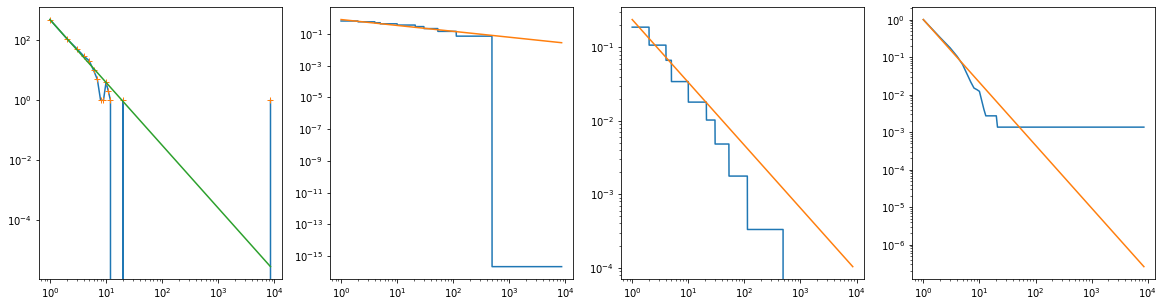

In [74]:
"""tot_clust = np.array(mult_iteration(particles=1000, iterations=50, limit=100, tstop=30, eps=17, calc=False, guess_eps=False))
tot_clust = tot_clust[:70]"""
tot_clust = get_clusters("run_3200.txt", 50, 500)[0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
plot_loglog(ax1, tot_clust)
bins, ccdf = plot_ccdf2(ax3, tot_clust, True)
bins2, ccdf2 = plot_ccdf2(ax2, tot_clust, False)
x1, list1 = plot_samplex(ax4, tot_clust)

x2 = np.linspace(1, len(tot_clust), len(tot_clust))
popt, pcov = fit_pl(x2, tot_clust)
ax1.plot(x2, pl(x2, popt[0], popt[1]))
print(popt)

popt, pcov = fit_pl(bins2, ccdf2)
ax2.plot(bins2, pl(bins2, popt[0], popt[1]))
print(popt)

popt, pcov = fit_pl(bins, ccdf)
ax3.plot(bins, pl(bins, popt[0], popt[1]))
print(popt)

popt, pcov = fit_pl(x1, list1)
ax4.plot(x1, pl(x1, popt[0], popt[1]))
print(popt)



In [171]:
make_input(1000, 3, 0, 100)

In [201]:
import powerlaw

"""tot_clust = np.array(mult_iteration(particles=1000, iterations=50, limit=100, tstop=30, eps=25, calc=False, guess_eps=False))
tot_clust = tot_clust"""

tot_clust = get_clusters("run_1600.txt", 5, 100)[0]
print(tot_clust)
print(len(tot_clust))

alpha = 0
x_min = min(tot_clust)+1
for i in range(len(tot_clust)):
    if tot_clust[i] > 0:
        alpha +=  (np.log(tot_clust[i]/x_min))
alpha1 = 1 + len(tot_clust) * np.power(alpha, -1)
sigma = np.sqrt(len(tot_clust)) * np.power(alpha, -1)
print('alpha =', alpha1)
print('sigma =', sigma)
const = np.power(scipy.special.zeta(alpha1, 1), -1)
print(const)

results = powerlaw.Fit(tot_clust,discrete=True)
print('a =', results.alpha)
print(results.xmin)
R, p = results.distribution_compare('lognormal', 'power_law')
print(R, p)


[658.  25.   9.   4.   0.   1.   0.   1.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.]
189
alpha = 15.219507383756048
sigma = 1

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/sennevw/anaconda3/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


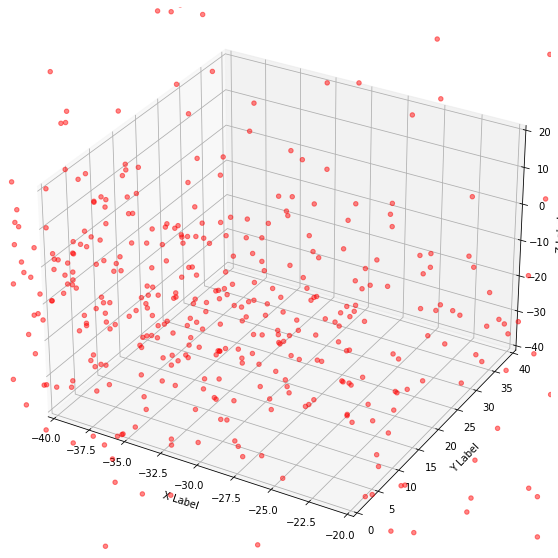

In [195]:
bestand = "run_1600.txt"
limit = 100
pos1, particles, limit = create_data(bestand, limit)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pos1 = np.array(pos1)
ax.scatter(pos1[:,0], pos1[:,1], pos1[:,2], c='r', marker='o')
xlim = 50
ylim = 50
zlim = 50
ax.set_xlim(-40,-20)
ax.set_ylim(0,40)
ax.set_zlim(-40,20)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
Treecodes geven vaak 1.3-1.7 als alpha om een of andere reden
vooral rond 1.4